In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



# Ler os dados do arquivo CSV
file_path = '/content/Transitent_gem_modified.txt'  # Caminho para o arquivo de dados
df = pd.read_csv(file_path,delimiter = ",")

# Definir os limites do intervalo de z (opcional)
zmin = 0
zmax = 15

zmin = zmin*1e-3
zmax = zmax*1e-3

#regiao = "GEM3 - Anodo"
df_filtered = df[(df['    z-coordinate'] >= zmin) & (df['    z-coordinate'] <= zmax)]

# Definir o tamanho da grade 2D
num_bins = 60

# Criar a matriz do histograma 2D
heatmap, xedges, yedges = np.histogram2d(df_filtered['    x-coordinate'],
                                         df_filtered['    y-coordinate'],
                                         bins=num_bins,
                                         weights=df_filtered['  total-pressure'],
                                         range=[[0,0.3],[0,0.3]])

counts, _, _ = np.histogram2d(df_filtered['    x-coordinate'], df_filtered['    y-coordinate'], bins=num_bins,range=[[0,0.3],[0,0.3]])

# Calcular a pressão média em cada bin (evitar divisão por zero)
mean_pressure = np.divide(heatmap, counts, where=counts!=0)


# Tratar os valores NaN (resultantes de bins sem contagens) substituindo por zero
mean_pressure = np.nan_to_num(mean_pressure)

for i in range(len(mean_pressure)):
  for j in range(len(mean_pressure[i])):
    mean_pressure[i][j] = (mean_pressure[i][j])

# Valor da pressão atmoférica de SP
#sp_pressure = 92340


#mean_pressure = (mean_pressure/ref)*sp_pressure


# Plotar o histograma 2D
plt.figure(figsize=(6, 6))
plt.imshow(mean_pressure.T, origin='lower', cmap='viridis', extent=(0, 0.3, 0, 0.3) )
#plt.colorbar(label='Pressão Média (Pa)')
#cbar.ax.yaxis.set_major_formatter(FuncFormatter(pressure_format))
plt.colorbar(label='Variação percentual da pressão (%)')
plt.title(f'Pressão Média em Z = {zmin*1000,zmax*1000}mm , bin = {num_bins,num_bins}',fontsize = 10)
plt.xlabel('Posição X')
plt.ylabel('Posição Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.hlines(0.025, 0.025,0.275, linestyles='dashed', colors='red')
plt.hlines(0.275, 0.025,0.275, linestyles='dashed', colors='red')
plt.vlines(0.275, 0.025,0.275, linestyles='dashed', colors='red')
plt.vlines(0.025, 0.025,0.275, linestyles='dashed', colors='red')
#plt.text(0.2,0.28, regiao, color="red",fontsize = 11)
#plt.savefig("/content/" + regiao + ".png")
plt.show()


In [372]:
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from concurrent.futures import ProcessPoolExecutor
import pickle

def load_data(filename, num_seed=0.999):
    # Carregar o arquivo CSV e remover os espaços do cabeçalho
    arq = np.genfromtxt(filename, delimiter=',', skip_header=1)  # Lê o arquivo ignorando a primeira linha (cabeçalho)

    mask_non_zero_velocities = np.all(arq[:, 5:7] != 0, axis=1)
    arq = arq[mask_non_zero_velocities] 

    # Dividir os dados nas colunas: x, y, z e as velocidades (vx, vy, vz)
    data = arq[:, [1, 2, 3, 5, 6, 7]]

    # Filtrando as sementes, onde 'x-coordinate' é maior que num_seed vezes o valor máximo de 'x-coordinate'
    max_x = np.max(arq[:, 1])  # Máximo da coluna de 'x-coordinate'
    seeds = arq[arq[:, 1] >= max_x * num_seed, 1:4]  # Selecionando as colunas de 'x-coordinate', 'y-coordinate', 'z-coordinate'
    min_x = np.min(arq[:,1])

    return seeds, data, min_x

def create_interpolator(data):
    #vou criar o interpolador pra ter o valor da velocidade em qualquer ponto
    pontos = data[:,:3]
    velocidades = data[:,3:]
    #retornar a função do interpolador para acessar dado pontos qualquer x0,y0,z0
    return interp.NearestNDInterpolator(pontos, velocidades)


def streamline(interpolator, seeds,Xf, t_max=5000, dt=0.5):
    def velocity(t, y): #função que serve de input para o integrador RK4
      v = interpolator(y)
      return v 
    
    def event(t, y):
        # Aqui 'y[0]' é a coordenada x, 'y[1]' é y e 'y[2]' é z (assumindo que são 3D)
        return  y[0] - Xf  # Retorna a diferença entre x e Xf (se x > Xf, evento será disparado)

    # Definir que o evento deve ser disparado quando x > Xf
    event.terminal = True  # Indica que a integração deve ser interrompida
    event.direction = -1 

    sol = [integrate.solve_ivp(velocity, [0, t_max], seed, t_eval=np.arange(0, t_max, dt), method = "RK45",events = event).y for seed in seeds]
    
    return sol



def recreate_vel_field(interpolator, streamlines):
    contador = len(streamlines)
    i = 0
    
    # Inicializa os arrays como ndarrays com o tamanho apropriado
    list_streamline = np.empty((contador, ), dtype=object)  # Armazenar as streamlines
    list_modv = np.empty((contador, ), dtype=object)         # Para armazenar os módulos das velocidades
    list_medias = np.zeros(contador)                         # Para armazenar as médias
    
    for idx, streamline in enumerate(streamlines):
        modv = []
        for pontos in streamline.T:
            modv.append(np.linalg.norm(interpolator(pontos), axis=1))
        
        list_modv[idx] = np.array(modv)  
        list_medias[idx] = np.mean(list_modv[idx]) 
        
        i += 1
        print(f"loading... {100 * i // contador}%")

    return list_medias


def RTD(streamlines, modv):
    #tempo de residencia é o o tamanho da streamline dividido pela velociade média
    # (M,N,3)
    tempos = []
    #calcular o tamanho da streamline com um integrador
    for streamline, v in zip(streamlines,modv):
      diff = np.diff(np.array(streamline).T,axis=0)
      distancia = np.linalg.norm(diff,axis=1)
      comprimento = np.sum(distancia)
      tempos.append(comprimento/v)

    return tempos


def plot_streamlines(streamlines, timeresidence, vmin, vmax):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Selecionar o colormap
    cmap = plt.get_cmap("rainbow")

    # Definir o intervalo de 0 a 30
    vmin = 0
    vmax = 30

    # Criar um array de valores para os N streamlines no intervalo de 0 a 30
    valores_tempos = timeresidence

    cores = cmap((valores_tempos - vmin) / (vmax - vmin))
    # Criar o gráfico de dispersão
    for i in range(len(streamlines)):
        ax.plot(streamlines[i][0],  # x
                streamlines[i][1],  # y
                streamlines[i][2],
                color=cores[i],  # Aplica a cor para cada streamline
                lw=0.5)  # Linha com maior espessura

    # Adicionar barra de cores para mapear os tempos
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # Não precisamos de dados extras aqui
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Tempo (min)')

    ax.set_zlim(0,0.03)
    # Títulos e rótulos
    ax.set_title('Streamlines coloridas por tempo de residência')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


def plot_dimensoes(data):
    plt.figure()
    plt.scatter(data[:,0],data[:,1],s=0.5)
    plt.xlabel("X(m)")
    plt.ylabel("Y(m)")
    plt.show()

In [ ]:
df.shape

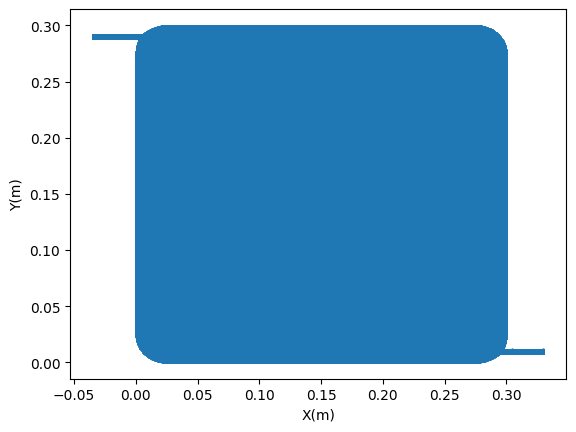

In [371]:
plot_dimensoes(df)

In [306]:
with open(r"C:\Users\Daniel\Documents\ansys data\streamlines_gem_modified\interpolator.pickle","rb") as interpol:
    interpolator = pickle.load(interpol)

seeds,df,Xf = load_data(r"C:\Users\Daniel\Documents\ansys data\streamlines_gem_modified\sol_gem_modified_nodes.txt",0.997)
#seeds,df = load_data(r"C:\Users\Daniel\Documents\ansys data\streamlines_gem_modified\sol_gem_modified_cell.txt",0.9999)

In [206]:
interpolator = create_interpolator(df)

In [307]:
streamlines = streamline(interpolator,seeds,-0.001)

In [ ]:
modv = recreate_vel_field(interpolator, streamlines)
timeresidence = RTD(streamlines,modv)


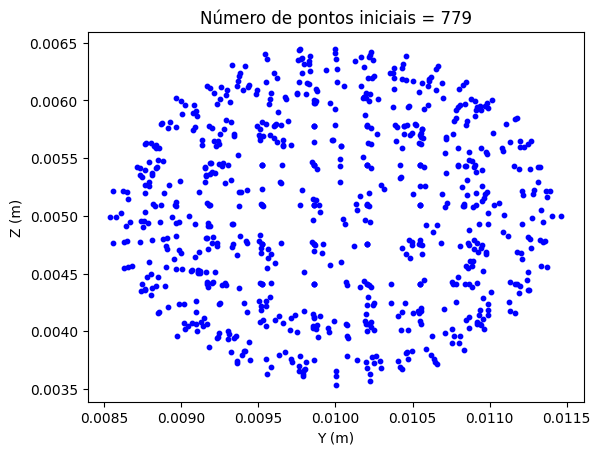

In [310]:
seeds = np.array(seeds)
plt.figure()
plt.scatter(seeds[:,1],seeds[:,2],s=10,color="b")
plt.title(f"Número de pontos iniciais = {len(seeds)}")
plt.xlabel("Y (m)")
plt.ylabel("Z (m)")
plt.show()

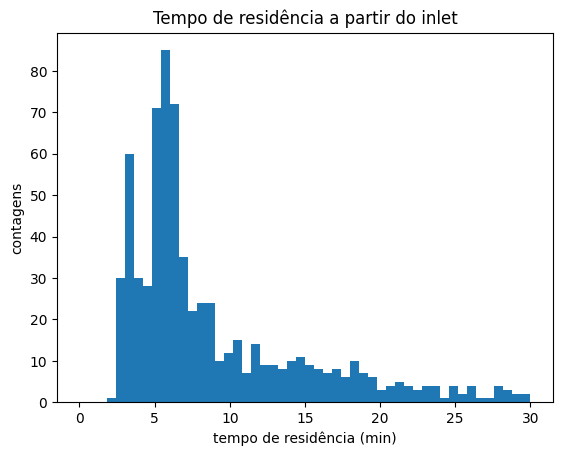

In [312]:
plt.figure()
plt.hist(np.array(timeresidence)/60,50,range=(0,30))
plt.xlabel("tempo de residência (min)")
plt.ylabel("contagens")
plt.title("Tempo de residência a partir do inlet")
plt.show()


In [327]:
timeresidence = np.array(timeresidence)/60

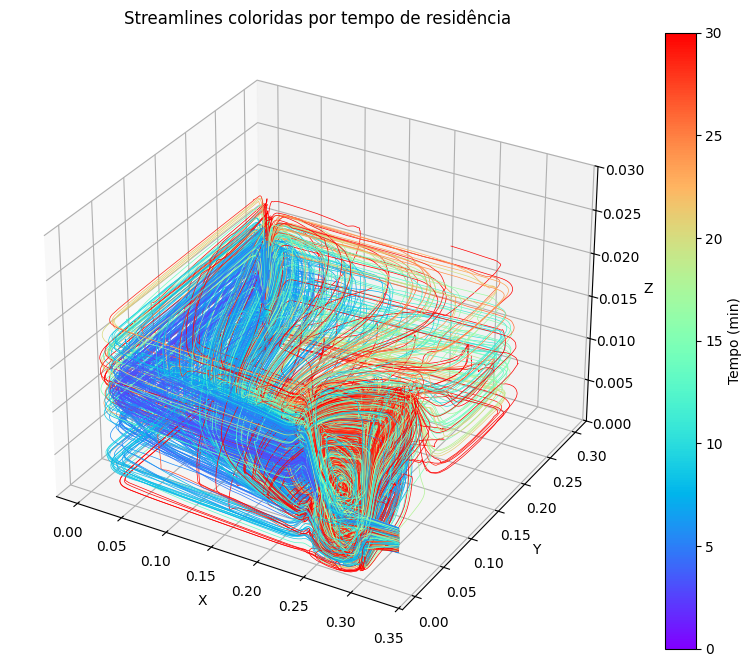

In [370]:
plot_streamlines(streamlines,timeresidence,0,30)


In [73]:
d = 3e-3 #diametro do inlet
r = d/2 #raio metade do diâmetro
V = 6e-3 #volume 16L = 16e-3m^3
dt = 3600 # 1h = 3600s
Z = V/dt #vazâo
A = np.pi*r**2 #área da seção transversal
v = Z/A #velocidade do fluido na seção
print(v)

0.23578510087688198
